## Visualize Cells based on Model Scores

This approach will provide us with a visual description of the phenotype of interest.

In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import plotnine as gg
import matplotlib.pyplot as plt

import skimage.io
import skimage.exposure

from pycytominer.aggregate import AggregateProfiles

In [2]:
sys.path.append("../scripts")
from grabPictures import grabPicture

In [3]:
random.seed(123)

In [4]:
# This model is one we're focusing on in this notebook
model = "cc_g1_plus_g2_count"

## Load Model Predictions

In [5]:
mapping_file = os.path.join("..", "1.generate-profiles", "data", "profile_id_metadata_mapping.tsv")
metadata_df = pd.read_csv(mapping_file, sep='\t')

metadata_df.head(2)

,Metadata_profile_id,Metadata_cell_line,Metadata_pert_name
0,profile_0,A549,AKT1-1
1,profile_1,A549,AKT1-2


In [6]:
consensus = "modz"

y_file = os.path.join("results", "full_cell_health_y_labels_{}.tsv.gz".format(consensus))
y_full_df = (
    pd.read_csv(y_file, sep="\t")
    .query("y_transform == 'raw'")
    .query("shuffle == 'shuffle_false'")
    .query("target == @model")
)

y_df = (
    y_full_df
    .pivot(
        index="Metadata_profile_id",
        columns="y_type",
        values="recode_target_value"
    )
    .reset_index()
    .merge(
        metadata_df,
        on="Metadata_profile_id"
    )
    .merge(
        y_full_df
        .loc[:, ["Metadata_profile_id", "data_type"]]
        .drop_duplicates(),
        on="Metadata_profile_id"
    )
    .sort_values(by="y_pred")
    .reset_index(drop=True)
)

y_df.head()

,Metadata_profile_id,y_pred,y_true,Metadata_cell_line,Metadata_pert_name,data_type
0,profile_182,-4.533537,-4.861926,ES2,ITGAV-2,train
1,profile_181,-3.854116,-4.337971,ES2,ITGAV-1,train
2,profile_300,-1.540483,-1.125132,HCC44,ITGAV-1,train
3,profile_301,-1.536922,-1.742202,HCC44,ITGAV-2,train
4,profile_62,-1.053673,-2.057898,A549,ITGAV-1,train


### Confirm High Prediction Performance

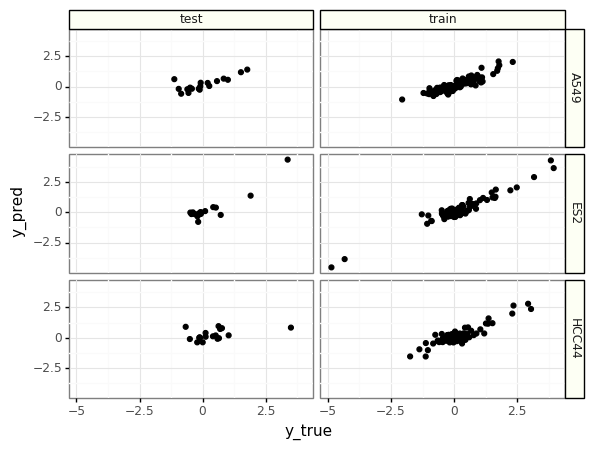

<ggplot: (-9223363258198892982)>

In [7]:
(
    gg.ggplot(y_df, gg.aes(x = "y_true", y = "y_pred")) +
        gg.geom_point() +
        gg.facet_grid("Metadata_cell_line~data_type") +
        gg.theme_bw() +
        gg.theme(strip_background = gg.element_rect(colour = "black", fill = "#fdfff4"))
)

## Process Images

In [8]:
channels=["DNA", "ER", "RNA", "AGP", "Mito"]

In [9]:
bucket_path = "/home/ubuntu/bucket/projects/2015_07_01_Cell_Health_Vazquez_Cancer_Broad/"
image_path = os.path.join(bucket_path, "CRISPR_PILOT_B1/images/")
sqlite_path = os.path.join(bucket_path, "workspace/backend/CRISPR_PILOT_B1/")
metadata_path = os.path.join("..", "1.generate-profiles", "data", "metadata")

### Load Plates

In [10]:
plate = "SQ00014613"
sqlite_dir = os.path.join(sqlite_path, plate)
sqlite_file = "sqlite:///{}/{}.sqlite".format(sqlite_dir, plate)

barcode_file = os.path.join(metadata_path, "barcode_platemap.csv")
platemap_name = pd.read_csv(barcode_file).query("Assay_Plate_Barcode == @plate").Plate_Map_Name.values[0]
platemap_path = os.path.join(metadata_path, "platemap", "{}.csv".format(platemap_name))

### Focusing on ES2 Cell Line

ES2 has the highest range of observations for real values and model predictions.

We will visualize a representative sample of ES2 cells with various perturbations that span the continuum of model predictions.

In [11]:
es2_df = y_df.query("Metadata_cell_line == 'ES2'").reset_index(drop=True)

print(es2_df.shape)
es2_df.head()

(119, 6)


,Metadata_profile_id,y_pred,y_true,Metadata_cell_line,Metadata_pert_name,data_type
0,profile_182,-4.533537,-4.861926,ES2,ITGAV-2,train
1,profile_181,-3.854116,-4.337971,ES2,ITGAV-1,train
2,profile_177,-0.949695,-1.067185,ES2,GPX4-1,train
3,profile_221,-0.792716,-0.174423,ES2,RHOA-2,test
4,profile_186,-0.729086,-0.886932,ES2,KIF11-2,train


In [12]:
es2_indeces = [x for x in range(0, es2_df.shape[0], 14)] + [es2_df.shape[0]  - 1]
es2_indeces

[0, 14, 28, 42, 56, 70, 84, 98, 112, 118]

### Initialize Class

In [13]:
# Set Initial Parameters
box_size = 300

gene_name = "EMPTY"
pert_name = "EMPTY"
site = 1

# Initialize class
example_image = grabPicture(
    bucket_path=bucket_path,
    image_path=image_path,
    sqlite_path=sqlite_path,
    metadata_path=metadata_path,
    plate=plate,
    aggregate_strata_cols=["Image_Metadata_Plate", "Image_Metadata_Well"],
    gene_name=gene_name,
    pert_name=pert_name,
    site=site,
    channels=channels,
    enable_single_cell=True
)

# Load the SQLite files storing image locations
example_image.load_image_table(get_well=True)

In [14]:
example_image_dict = {}
pert_order = []
for es2_index in es2_indeces:
    # Grab perturbation
    pert_df = es2_df.iloc[es2_index, :]
    pert_name = pert_df.Metadata_pert_name
    gene_name = pert_name.split("-")[0]
    
    # What is the prediction score
    pred_score = pert_df.y_pred
    
    # Find the well of the specific perturbation
    example_image.find_well(gene_name=gene_name, pert_name=pert_name, site=site)
    
    # Get an object number at random avoiding edges
    objnum = (
        example_image
        .cell_location_df
        .query("Image_Metadata_Well == @example_image.well")
        .query("Image_Metadata_Site == @site")
        .ObjectNumber
    )
    top = int(objnum.quantile(0.9))
    bottom = int(objnum.quantile(0.1))
    objnum = random.randrange(bottom, top)
    
    # Keep track of the order of perturbations and object numbers
    pert_order.append((pert_name, round(pred_score, 1), objnum))
    
    # Load and process images
    example_image.prep_images(objectNum=objnum, boxSize=box_size)
    example_image_dict[pert_name] = example_image.get_image_dict(cropped=True, color=False)

In [15]:
# Order of plotting
pert_order

[('ITGAV-2', -4.5, 8),
 ('ARID1B-1', -0.3, 45),
 ('TXN-2', -0.2, 39),
 ('STAT3-1', -0.1, 57),
 ('Chr2-5', -0.0, 127),
 ('Chr2-3', 0.1, 94),
 ('XBP-2', 0.3, 24),
 ('MYC-2', 0.6, 7),
 ('CDK2-2', 1.8, 32),
 ('CDK4-2', 4.3, 26)]

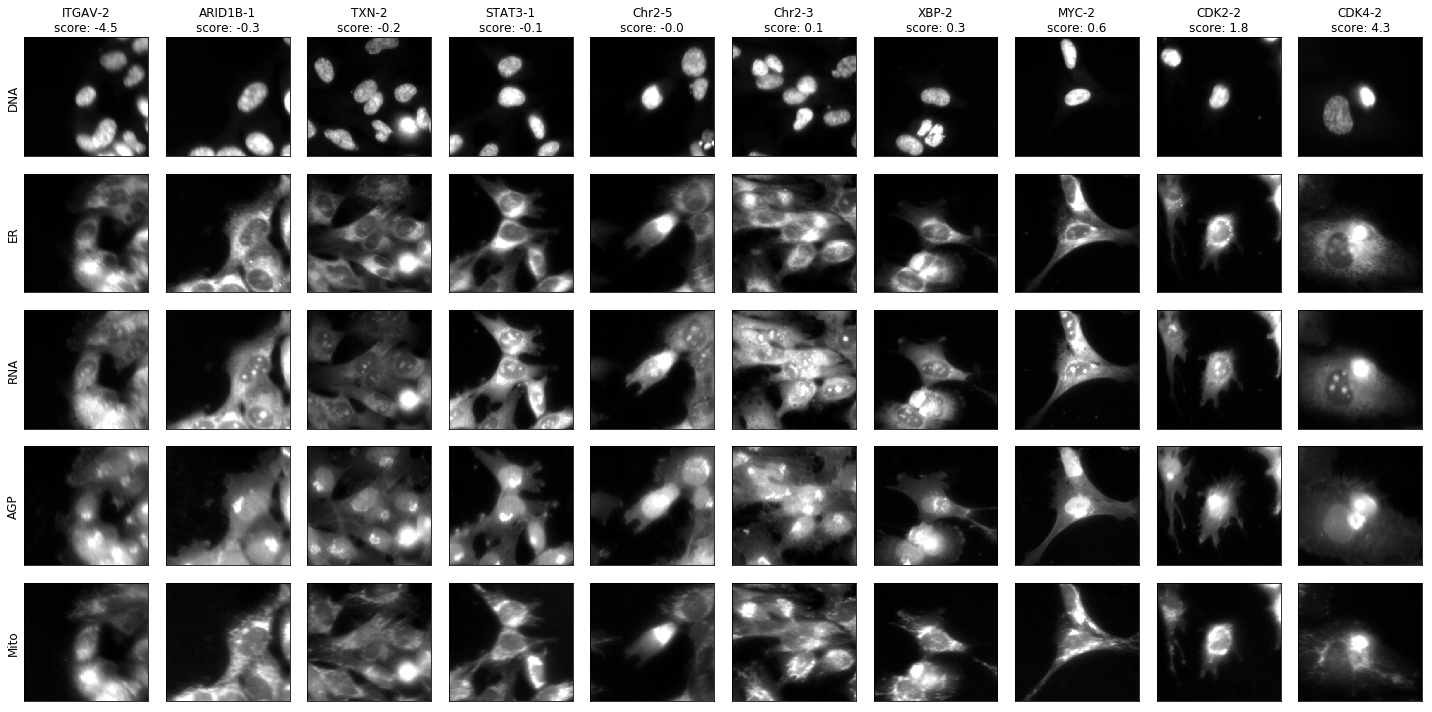

<Figure size 432x288 with 0 Axes>

In [16]:
f, axarr = plt.subplots(
    len(channels),
    len(pert_order),
    figsize=(20, 10)
);

for i in range(len(channels)):
    channel = channels[i]
    channel_key = "ch{}_{}".format(i + 1, channel)
    for j in range(len(pert_order)):
        pert, pert_score, objnum = pert_order[j]
        imD = example_image_dict[pert][channel_key]
        
        axarr[i,j].imshow(imD, cmap='gray')
        axarr[0,j].set_title("{}\nscore: {}".format(pert, pert_score))
        axarr[i,j].xaxis.set_major_locator(plt.NullLocator())
        axarr[i,j].yaxis.set_major_locator(plt.NullLocator())
        axarr[i,j].set_aspect('auto')
        
for ax, row in zip(axarr[:,0], channels):
    ax.set_ylabel(row, rotation=90, size='large')
    
f.tight_layout()
plt.show()

output_file = os.path.join("figures", "images", "example_images_{}_{}.png".format(model, consensus))
plt.subplots_adjust(top=0.8)
plt.savefig(output_file, pad_inches=0.2, dpi=500)